In [2]:
import pandas as pd
import numpy as np
import datetime

#api
import praw

#pre-processing
import nltk 
from nltk.util import ngrams
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tree import Tree
from nltk.stem.porter import *
from nltk.tokenize import MWETokenizer 
from nltk import word_tokenize, pos_tag, ne_chunk
import spacy
# from spacy import displacy
import en_core_web_sm
import re
# import string
#from textblob import TextBlob
#from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# import gensim
from collections import Counter
# nltk.download()

from NLP_functions import display_topics, prob_df, topic_matrix

#analysis
from sklearn.decomposition import TruncatedSVD, NMF

#plotting
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
reddit = praw.Reddit(client_id='oCxykEUclueAuA', client_secret='M8wVQw3nFxMsXHLGxurnTtkN-Mdvtg', user_agent='Crypto')

Version 7.0.0 of praw is outdated. Version 7.1.4 was released Sunday February 07, 2021.


#### Get top posts of all time

In [6]:
posts = []
ml_subreddit = reddit.subreddit('Cryptocurrency')

for post in list(ml_subreddit.top('all', limit=1000)):
    date = datetime.datetime.utcfromtimestamp(post.created_utc)
    posts.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, post.selftext, date])
    
posts = pd.DataFrame(posts,columns=['title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body', 'date'])
print(posts)

                                                 title  score      id  \
0    Elon Musk reminds me of a rich billionaire who...  39444  lce6zm   
1    CryptoNick is deleting all of his BitConnect v...  26507  7r0ftz   
2    Reminder: Robinhood blocked several stocks fro...  26341  lfrslo   
3    I will tell you exactly what is going on here,...  20148  7vga1y   
4    Robinhood is launching a Crypto Trading app to...  19958  7sx5ze   
..                                                 ...    ...     ...   
926                                  Too true though 😅   1382  lo8q3a   
927  The FUD for every top 10 coin and why you shou...   1370  lp9i8n   
928                              I can't stop checking   1311  lo4i1r   
929  People: "I Wish I had Bought BTC In the Good O...   1295  lkzb8m   
930  If you're gonna be trading, you need to be abs...   1286  lcwyje   

          subreddit                                                url  \
0    CryptoCurrency  https://www.reddit.com/r/Cry

#### Get top coments from each top post, group by post

In [7]:
# top_posts = []
# for i,d in zip(posts.id, posts.date):
#     try:
#         submission = reddit.submission(id=i)
#         submission.comments.replace_more(limit=0)
#         comments=list([(comment.body) for comment in submission.comments.list()])
#         comment_string = ''
#         for x in comments[:20]:
#             comment_string = comment_string + ' ' + x
#         top_posts.append([comment_string,d])
#     except:
#         comments=None
# top_posts = pd.DataFrame(top_posts, columns=['comment', 'date'])
# print(top_posts)

#### Get top coments from each top post

In [8]:
all_top_comments = []
for i,d in zip(posts.id, posts.date):
    try:
        submission = reddit.submission(id=i)
        submission.comments.replace_more(limit=0)
        comments=list([(comment.body) for comment in submission.comments.list()])
        for x in comments[:20]:
            if x != '[deleted]' and 'Some Important Reminders' not in x and 'moderator' not in x:
                all_top_comments.append([x,d])
#             print(all_top_comments)
    except:
        comments=None
all_top_comments = pd.DataFrame(all_top_comments,columns=['comment', 'date'])
print(all_top_comments)

                                                 comment                date
0      If your life savings hinges on a Tweet from a ... 2021-02-04 12:02:16
1      I seriously don’t understand the obsession wit... 2021-02-04 12:02:16
2      Tbh u can't place all the blame on Elon tho, t... 2021-02-04 12:02:16
3      seriously, there's so much more relevant peopl... 2021-02-04 12:02:16
4      If I'm Elon, I put hundreds of millions into D... 2021-02-04 12:02:16
...                                                  ...                 ...
17775  These are very good points! I did just that wh... 2021-02-05 02:17:10
17776  Thank you for the write-up. I enjoyed it!\n\n&... 2021-02-05 02:17:10
17777  This is the sorta info that needs to be shown ... 2021-02-05 02:17:10
17778  There a lot of condescending posts in this sub... 2021-02-05 02:17:10
17779  i've spent January trying to maximize my decem... 2021-02-05 02:17:10

[17780 rows x 2 columns]


In [9]:
price_df = pd.read_csv('/Users/racheldilley/Downloads/bitstampUSD_1-min_data_2012-01-01_to_2020-12-31.csv')
price_df

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4727772,1609372560,28801.47,28829.42,28785.64,28829.42,0.965221,27804.572129,28806.429798
4727773,1609372620,28829.42,28863.90,28829.42,28857.06,2.368831,68332.350629,28846.441863
4727774,1609372680,28850.49,28900.52,28850.49,28882.82,2.466590,71232.784464,28879.056266
4727775,1609372740,28910.54,28911.52,28867.60,28881.30,7.332773,211870.912660,28893.695831


## Cleaning

In [10]:
all_top_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17780 entries, 0 to 17779
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   comment  17780 non-null  object        
 1   date     17780 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 277.9+ KB


add year column

In [9]:
# top_comments['year'] = top_comments['date'].dt.year
# years = ['2017', '2018', '2019', '2020', '2021']
# top_comments['year'].value_counts()

In [10]:
# def get_wordnet_pos(word):
#     """Map POS tag to first character lemmatize() accepts"""
#     tag = nltk.pos_tag([word])[0][1][0].upper()
#     tag_dict = {"J": wordnet.ADJ,
#                 "N": wordnet.NOUN,
#                 "V": wordnet.VERB,
#                 "R": wordnet.ADV}

#     return tag_dict.get(tag, wordnet.NOUN)

Add stop words and manual tokenizers

In [127]:
stop = stopwords.words('english')
stop = [w.replace("'", "") for w in stop] #remove apostrophes in stop words

stop += [ 'moderator', 'subreddit', 'reddit' , 'question', 'concern', 'please', 'contact', 'im', 
            'people', 'gon', 'seems', 'something', 'year', 'like', 'mod', 'wa', 'thread', 'crypto', 'get',
            'see', 'deleted', 'ha', 'use', 'think', 'cryptocurrency', 'thing', 'one', 'even', 'want', 'need',
        'time', 'also', 'got', 'post', 'thats', 'probably', 'u', 'every', 'next', 'reason', 'na', 'give', 'lol',
        'everything', 'know', 'community', 'today', 'come', 'anyone', 'actually', 'removed', 'wtf', 'immage',
        'really', 'nice', 'man', 'work', 'day', 'way', 'would', 'could', 'said', 'submission', 'news', 'nice',
        'enjoy', 'find', 'work', 'job', 'flaired', 'inaccurately', 'click', 'action', 'performed', 'automatically',
        'ive', 'seen', 'sense', 'month', 'pretty', 'much', 'week', 'money',  'currency', 'coin', 'market', 
         'someone', 'guy', 'price', 'lot', 'exchange', 'transaction', 'feel', 'list', 'wow', 'well', 'go',
        'something', 'shit', 'fuck', 'look', 'still', 'value', 'back']
stop = set(stop)

# mwe_tokenizer = MWETokenizer([ ('bull','run'), ('market','cap'), ('pump','dump'), ('bitcoin','cash'),
#                              ('stock','market'), ('flaired', 'inaccurately'), ('make','money'), ('going','up'),
#                              ('going', 'down'), ('make','money'), ('go','up'), ('go', 'down'), ('dont', 'know')])
mwe_tokenizer = MWETokenizer(('bitcoin','cash'))

# Init Lemmatizer and stemmer
lemmatizer = nltk.stem.WordNetLemmatizer()
stemmer = PorterStemmer()

In [128]:
def clean_str(row):
    '''
    clean comment string, removing numbers, punctuation, stop words, and changing to lowercase, 
    lemmatizing and stemming
    
    input: row of df
    
    output: cleaned string
    '''

    s = str(row[0]).lower() #lowercase
        
    s = re.sub(r'\([^)]*\)', '', s) #remove links
        
    #only alphabetical letters
    NON_ASCII = re.compile(r'[^a-z0-1\s]')
    s = NON_ASCII.sub(r'', s)
    
    s = re.sub(r'[0-9]+', '', s) #remove numbers
        
    #replace acronyms 
    s = s.replace('btc', 'bitcoin') 
    s = s.replace('bch', 'bitcoin_cash')
    s = s.replace('bitcoin cash', 'bitcoin_cash')
    s = s.replace(' eth ', ' ethereum ')
    s = s.replace(' alt ', ' altcoins ')
  
    s_token = mwe_tokenizer.tokenize(word_tokenize(s))  # tokenize words
    
    s_token = [w.strip() for w in s_token] #remove spaces
    
    s_token = [w for w in s_token if w not in stop] #remove stop words
        
    # Lemmatize and stem Single Word with the appropriate POS tag
#     s_token_lemm = [stemmer.stem(lemmatizer.lemmatize(w, get_wordnet_pos(w))) for w in s_token]

    s_token_lemm = [lemmatizer.lemmatize(w) for w in s_token] #Lemmatize
    
    s_token_lemm_stem = [stemmer.stem(w) for w in s_token_lemm] #stem
        
    s_token_lemm_stem = [w for w in s_token_lemm_stem if w not in stop] #remove stop words
    
    s_lemm_stem = " ".join(s_token_lemm_stem) #join back into one string
        
    return s_lemm_stem

In [129]:
top_comments = all_top_comments.copy()
top_comments['cleaned_comments'] = top_comments.apply (lambda row: clean_str(row), axis=1)
# top_comments['cleaned_comments'] = top_comments.apply(clean_str_list) 

Named Entitiy Recognition

In [130]:
def pos_only(row):
    s = row[2]
    
#     s = re.sub(r'\([^)]*\)', '', s) #remove links
        
#     #only alphabetical letters
#     NON_ASCII = re.compile(r'[^a-z0-1\s]')
#     s = NON_ASCII.sub(r'', s)
        
#     #replace acronyms 
#     s = s.replace('btc', 'Bitcoin') 
#     s = s.replace('bch', 'Bitcoin Cash') 
#     s = s.replace(' eth ', ' Ethereum ')
# #     s = s.replace('elon musk', 'elon')
    
    s_token = word_tokenize(s)  # tokenize words
    
#     s_token_lemm = [lemmatizer.lemmatize(w) for w in s_token]
#     s_token_lemm_stem = [stemmer.stem(w) for w in s_token_lemm]
    
    s_pos = nltk.pos_tag(s_token)
    
    pos = []
    for x in s_pos:
        if x[1] == 'NN' or x[1] == 'VB' or x[1] == 'JJ':
            pos.append(x[0])
    
    return ' '.join([word for word in pos])

In [131]:
top_comments['nouns_verbs_adj'] = top_comments.apply (lambda row: pos_only(row), axis=1)

In [132]:
top_comments

,comment,date,cleaned_comments,nouns_verbs_adj
0,If your life savings hinges on a Tweet from a ...,2021-02-04 12:02:16,life save hing tweet crazi billionair tell,life save tweet crazi billionair tell
1,I seriously don’t understand the obsession wit...,2021-02-04 12:02:16,serious understand obsess elon musk space sign...,serious understand obsess elon musk space sign...
2,"Tbh u can't place all the blame on Elon tho, t...",2021-02-04 12:02:16,tbh cant place blame elon tho decid yolo life ...,tbh cant place blame elon tho decid yolo life ...
3,"seriously, there's so much more relevant peopl...",2021-02-04 12:02:16,serious relev cryptodltfintech world obsess fa...,serious relev cryptodltfintech world obsess fa...
4,"If I'm Elon, I put hundreds of millions into D...",2021-02-04 12:02:16,elon put hundr million doge dip tweet doge pul...,elon doge dip tweet doge pull gain hour shock ...
...,...,...,...,...
17775,These are very good points! I did just that wh...,2021-02-05 02:17:10,good point lost asset put mission invest doubl...,good point asset mission invest doubl initi de...
17776,Thank you for the write-up. I enjoyed it!\n\n&...,2021-02-05 02:17:10,thank writeup xb trade make decent gain lost p...,thank writeup trade decent gain part trade ye ...
17777,This is the sorta info that needs to be shown ...,2021-02-05 02:17:10,sorta info shown newer investorstrad sub good,sorta info investorstrad sub good
17778,There a lot of condescending posts in this sub...,2021-02-05 02:17:10,condescend sub high hors,condescend sub high


### EDA of all Comments to get stop words

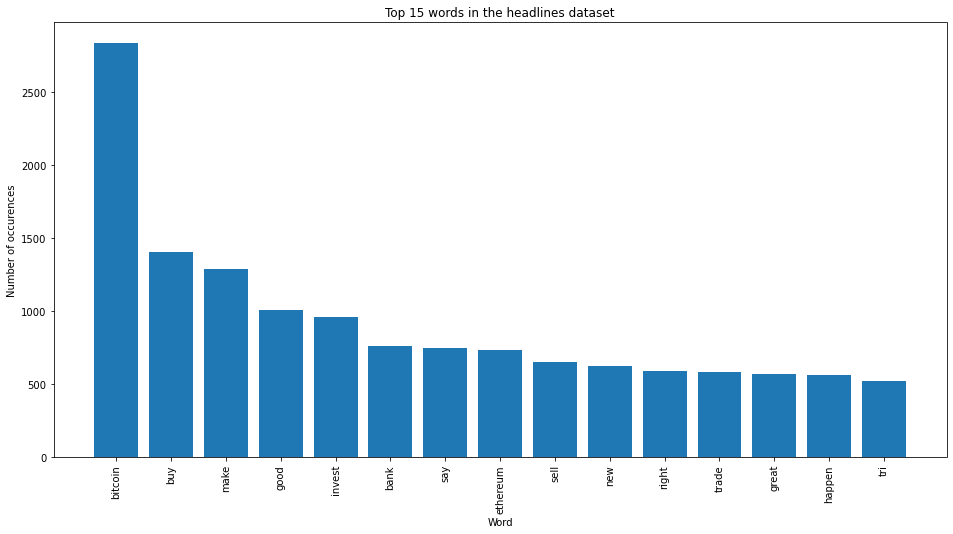

In [133]:
def get_top_n_words(corpus, n=10):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

words = []
word_values = []
for i,j in get_top_n_words(top_comments['cleaned_comments'],15):
    words.append(i)
    word_values.append(j)
    
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top 15 words in the headlines dataset');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

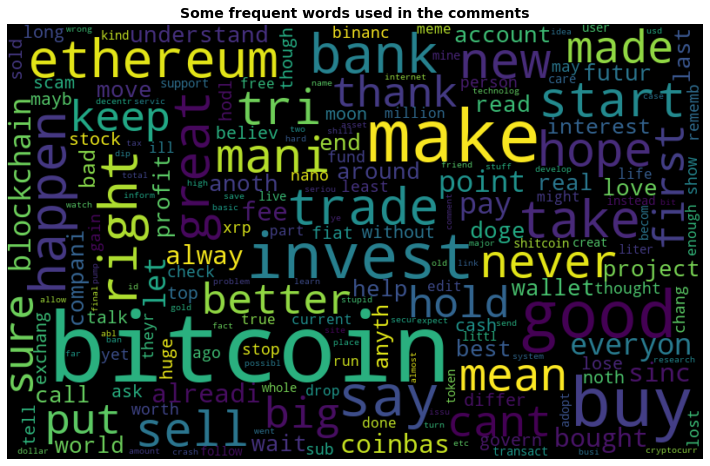

In [134]:
all_words = ' '.join([word for word in top_comments['cleaned_comments']])
all_words
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
# wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', 
#                       colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(text)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Some frequent words used in the comments", weight='bold', fontsize=14)
plt.show()

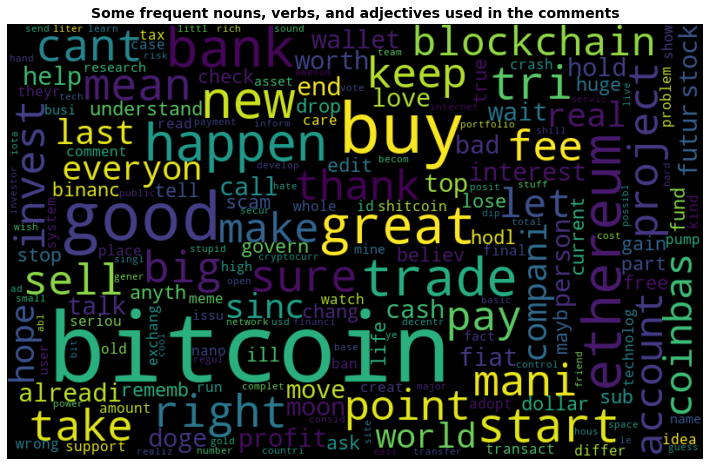

In [135]:
all_nouns = ' '.join([word for word in top_comments['nouns_verbs_adj']])
all_nouns
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_nouns)
# wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', 
#                       colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(text)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Some frequent nouns, verbs, and adjectives used in the comments", weight='bold', fontsize=14)
plt.show()

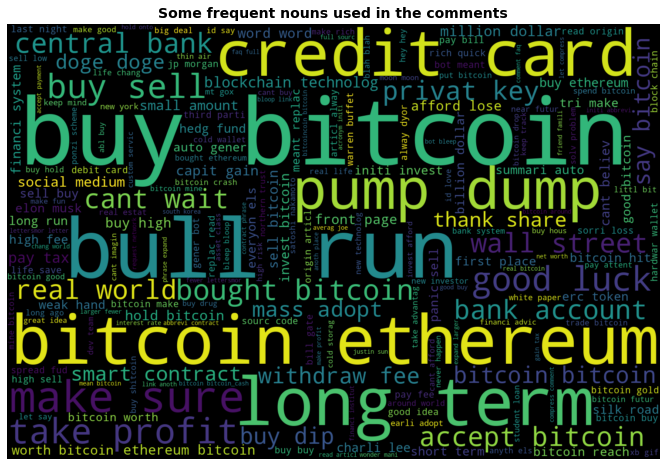

In [136]:
nltk_tokens = nltk.word_tokenize(all_words)  
bigrams_list = list(nltk.bigrams(top_comments['cleaned_comments']))

dictionary2 = [' '.join(tup) for tup in bigrams_list]


#Using count vectoriser to view the frequency of bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2))
bag_of_words = vectorizer.fit_transform(dictionary2)
vectorizer.vocabulary_
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

#Generating wordcloud and saving as jpg image
words_dict = dict(words_freq)
WC_height = 1000
WC_width = 1500
WC_max_words = 200
wordCloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width)
wordCloud.generate_from_frequencies(words_dict)
plt.figure(figsize=(15, 8))
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.title("Some frequent nouns used in the comments", weight='bold', fontsize=14)
plt.show()

# Topic Modeling

In [137]:
comments = list(top_comments['cleaned_comments'])

topics = 3
topic_words = 5
topic_names = None
maxdf = None
mindf = 20

### Count Vectorization

In [138]:
cv = CountVectorizer(stop_words=stop, ngram_range=(1,3),  min_df = mindf)
X_cv = cv.fit_transform(comments)
# pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names())

#### Latent Semantic Analysis (LSA) with Count Vectorization

In [154]:
lsa_cv = TruncatedSVD(6)
X_lsa_cv = lsa_cv.fit_transform(X_cv)
lsa_cv.explained_variance_ratio_

array([0.03865576, 0.02159923, 0.01411577, 0.01073005, 0.00958408,
       0.00823747])

In [155]:
display_topics(lsa_cv, cv.get_feature_names(), topic_words, topic_names)


Topic  0
bitcoin, make, buy, bank, invest

Topic  1
bank, make, blockchain, invest, fund

Topic  2
bank, bitcoin, central, account, central bank

Topic  3
blockchain, trust, new, fund, project

Topic  4
buy, ethereum, blockchain, trust, servic

Topic  5
make, fee, ethereum, trade, pay


#### Non-Negative Matrix Factorization (NMF) with Count Vectorization

In [169]:
nmf_cv = NMF(10)
X_nmf_cv = nmf_cv.fit_transform(X_cv)
# nmf_cv.explained_variance_ratio_

In [170]:
display_topics(nmf_cv, cv.get_feature_names(), topic_words, topic_names)


Topic  0
good, say, take, right, start

Topic  1
bitcoin, bitcoin_cash, energi, gold, mine

Topic  2
bank, central, central bank, account, rate

Topic  3
buy, sell, hold, buy bitcoin, dip

Topic  4
blockchain, trust, servic, fund, new

Topic  5
invest, iota, lose, technolog, compani

Topic  6
word, bitcoin_cash, whitepap, activ, develop

Topic  7
ethereum, decentr, bitcoin ethereum, token, project

Topic  8
make, happen, sure, stock, robinhood

Topic  9
fee, pay, card, coinbas, lightn


## TF-IDF Vectorizer

In [156]:
tfid = TfidfVectorizer(stop_words= stop, ngram_range=(1,3), min_df=40)
X_tfid = tfid.fit_transform(comments)
# pd.DataFrame(X_tfid.toarray(), columns=tfid.get_feature_names())

#### Non-Negative Matrix Factorization (NMF) with TF-IDF Vectorization 

In [161]:
nmf_tfid = NMF(8)
X_nmf_tfid = nmf_tfid.fit_transform(X_tfid)

In [162]:
display_topics(nmf_tfid, tfid.get_feature_names(), topic_words, topic_names)


Topic  0
bitcoin, buy bitcoin, gold, mine, bought

Topic  1
invest, ethereum, bank, say, right

Topic  2
good, good luck, luck, bad, awesom

Topic  3
buy, sell, dip, buy bitcoin, high

Topic  4
great, idea, team, meme, hope

Topic  5
doge, moon, meme, pump, dogecoin

Topic  6
make, sure, rich, let, make sure

Topic  7
thank, share, meme, best, op


## Final topic model 

In [149]:
def topic_matrix(model, feature_names, topics):
    idx = []
    for x in range(1,topics+1):
        idx.append('topic_'+str(x))

    topic_word = pd.DataFrame(model.components_.round(3),
             index = idx,
             columns = feature_names)
    
    topic_word = topic_word.T
    topic_word['topic_choice'] = topic_word.idxmax(axis=1)
    topic_word['max_value'] = topic_word.max(axis=1)
    
    return topic_word

word_df = topic_matrix(nmf_cv, cv.get_feature_names(), 6)

#svae as csv on data folder
word_df.to_csv('../Data/word_topic_analysis.csv')

In [151]:
def prob_df(X, topics):
    cols = []
    for x in range(1,topics+1):
        cols.append('topic_'+str(x))

    df = pd.DataFrame(X.round(5), columns = cols)
    df['topic_choice'] = df.idxmax(axis=1)
    df['max_value'] = df.max(axis=1)
   
    return df
nmf_tfid_probs = prob_df(X_nmf_cv, 6)

nmf_tfid_probs['date'] = top_comments['date']
nmf_tfid_probs['comment'] = top_comments['comment']

nmf_tfid_probs

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_choice,max_value,date,comment
0,0.01165,0.00239,0.00000,0.00000,0.00000,0.01916,topic_6,0.01916,2021-02-04 12:02:16,If your life savings hinges on a Tweet from a ...
1,0.04192,0.12919,0.00000,0.00000,0.01267,0.03967,topic_2,0.12919,2021-02-04 12:02:16,I seriously don’t understand the obsession wit...
2,0.03896,0.00695,0.00107,0.00853,0.00000,0.04235,topic_6,0.04235,2021-02-04 12:02:16,"Tbh u can't place all the blame on Elon tho, t..."
3,0.01814,0.00490,0.00000,0.00365,0.00682,0.01937,topic_6,0.01937,2021-02-04 12:02:16,"seriously, there's so much more relevant peopl..."
4,0.05102,0.00239,0.00000,0.01823,0.00000,0.00489,topic_1,0.05102,2021-02-04 12:02:16,"If I'm Elon, I put hundreds of millions into D..."
...,...,...,...,...,...,...,...,...,...,...
17775,0.10137,0.00000,0.00000,0.13344,0.03798,0.21107,topic_6,0.21107,2021-02-05 02:17:10,These are very good points! I did just that wh...
17776,0.20052,0.00000,0.00000,0.03544,0.00000,0.00000,topic_1,0.20052,2021-02-05 02:17:10,Thank you for the write-up. I enjoyed it!\n\n&...
17777,0.02288,0.00000,0.00000,0.00307,0.00000,0.00023,topic_1,0.02288,2021-02-05 02:17:10,This is the sorta info that needs to be shown ...
17778,0.00401,0.00109,0.00000,0.00431,0.00164,0.00163,topic_4,0.00431,2021-02-05 02:17:10,There a lot of condescending posts in this sub...


## Sentiment Analysis

In [152]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def get_sentiments(df):
    
    df['compound'] = df['comment'].apply(lambda comment: analyzer.polarity_scores(str(comment))['compound'])
    df['positive'] = df['comment'].apply(lambda comment: analyzer.polarity_scores(str(comment))['pos'])
    df['neutral'] = df['comment'].apply(lambda comment: analyzer.polarity_scores(str(comment))['neu'])
    df['negative'] = df['comment'].apply(lambda comment: analyzer.polarity_scores(str(comment))['neg'])
    df['sentiment'] = df['compound'].apply(lambda c: 'posititve' if c >=0 else 'negative')
#     df['sentiment'] = df[['positive', 'neutral', 'negative']].idxmax(axis=1)
#     df['sentiment_value'] = df[['positive', 'neutral', 'negative']].max(axis=1)

    return df

comment_topic_sentiment_df = get_sentiments(nmf_tfid_probs)

#svae as csv on data folder
comment_topic_sentiment_df.to_csv('../Data/topic_sentiment_analysis_comments.csv')

In [153]:
comment_topic_sentiment_df

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_choice,max_value,date,comment,compound,positive,neutral,negative,sentiment
0,0.01165,0.00239,0.00000,0.00000,0.00000,0.01916,topic_6,0.01916,2021-02-04 12:02:16,If your life savings hinges on a Tweet from a ...,-0.3400,0.000,0.882,0.118,negative
1,0.04192,0.12919,0.00000,0.00000,0.01267,0.03967,topic_2,0.12919,2021-02-04 12:02:16,I seriously don’t understand the obsession wit...,-0.7906,0.026,0.833,0.141,negative
2,0.03896,0.00695,0.00107,0.00853,0.00000,0.04235,topic_6,0.04235,2021-02-04 12:02:16,"Tbh u can't place all the blame on Elon tho, t...",0.2883,0.122,0.790,0.088,posititve
3,0.01814,0.00490,0.00000,0.00365,0.00682,0.01937,topic_6,0.01937,2021-02-04 12:02:16,"seriously, there's so much more relevant peopl...",0.1280,0.078,0.806,0.116,posititve
4,0.05102,0.00239,0.00000,0.01823,0.00000,0.00489,topic_1,0.05102,2021-02-04 12:02:16,"If I'm Elon, I put hundreds of millions into D...",0.7321,0.174,0.826,0.000,posititve
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17775,0.10137,0.00000,0.00000,0.13344,0.03798,0.21107,topic_6,0.21107,2021-02-05 02:17:10,These are very good points! I did just that wh...,0.9854,0.196,0.792,0.012,posititve
17776,0.20052,0.00000,0.00000,0.03544,0.00000,0.00000,topic_1,0.20052,2021-02-05 02:17:10,Thank you for the write-up. I enjoyed it!\n\n&...,0.7738,0.194,0.714,0.092,posititve
17777,0.02288,0.00000,0.00000,0.00307,0.00000,0.00023,topic_1,0.02288,2021-02-05 02:17:10,This is the sorta info that needs to be shown ...,0.4404,0.146,0.854,0.000,posititve
17778,0.00401,0.00109,0.00000,0.00431,0.00164,0.00163,topic_4,0.00431,2021-02-05 02:17:10,There a lot of condescending posts in this sub...,0.0000,0.000,1.000,0.000,posititve


## Word2Vec

In [ ]:
tokenized_comments = [gensim.utils.simple_preprocess(d) for d in comments]

# size refers to the desired dimension of our word vectors
# window refers to the size of our context window
# sg means that we are using the Skip-gram architecture

word2vec = gensim.models.Word2Vec(tokenized_comments, size=10, window=2,min_count=1)

# Path to where the word2vec file lives
google_vec_file = '/Users/racheldilley/Downloads/GoogleNews-vectors-negative300.bin'

# Load it!  This might take a few minutes...
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(google_vec_file, binary=True)

In [ ]:
word2vec.most_similar('doge')

In [ ]:
print(word2vec.train(comments, total_examples=word2vec.corpus_count, epochs=word2vec.epochs))

In [ ]:
word2vec.wv

In [ ]:
class WordVecVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = 300
    def fit(self, X, y):
        return self
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in texts.split() if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for texts in X
        ])

wtv = WordVecVectorizer(word2vec_model)
X_wtv = wtv.transform(comments)
print(X_wtv)

In [ ]:
print(word2vec_model.wv.vocab.keys())

In [141]:
# from gensim.models.ldamodel import LdaModel
import genism
# from gensim.corpora.Dictionary import load_from_text, doc2bow
from gensim.corpora import MmCorpus
from gensim.models.ldamodel import LdaModel
document = "This is some document..."
# load id->word mapping (the dictionary)
id2word = gensim.corpora.Dictionary.load_from_text('wiki_en_wordids.txt')
# load corpus iterator
mm = MmCorpus('wiki_en_tfidf.mm')
lda = LdaModel(corpus=mm, id2word=id2word, num_topics=5, passes=10)
# use LDA model: transform new doc to bag-of-words, then apply lda
# doc_bow = doc2bow(document.split())
doc_lda = lda[X_cv]
# doc_lda is vector of length num_topics representing weighted presence of each topic in the doc

ModuleNotFoundError: No module named 'genism'

In [ ]:
lsa_wtv = TruncatedSVD(topics)
X_lsa_wtv = lsa_tfid.fit_transform(X_wtv)
# lsa_wtv.explained_variance_ratio_

In [ ]:
display_topics(lsa_wtv, word2vec_model.wv.vocab.keys(), topic_words, topic_names)

## GloVe

In [ ]:
# from sklearn.cluster import KMeans
# km = KMeans(
#     n_clusters=2, init='random',
#     n_init=10, max_iter=300, 
#     tol=1e-04, random_state=0
# )
# y_km = km.fit_predict(X_wtv)
# df = pd.DataFrame({'year' :comments, 'topic_cluster' :y_km })
# df

In [ ]:
# from sklearn.manifold import TSNE
# model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
#                         n_iter=1000, verbose=1, random_state=0, angle=0.75)
# tsne_features = model.fit_transform(lda_matrix)
# df = pd.DataFrame(tsne_features)
# df['topic'] = lda_matrix.argmax(axis=1)
# df.columns = ['TSNE1', 'TSNE2', 'topic']
# import seaborn as sns
# plt.figure(figsize=(15, 10))
# plt.title('T-SNE plot of different headlines ( headlines are clustered among their topics)')
# ax = sns.scatterplot(x = 'TSNE1', y = 'TSNE2', hue = 'topic', data = df, legend = 'full')
# plt.show()

In [ ]:
# def get_top_n_words(corpus, n=10):
#   vec = CountVectorizer(stop_words='english').fit(corpus)
#   bag_of_words = vec.transform(corpus)
#   sum_words = bag_of_words.sum(axis=0) 
#   words_freq = [(word, sum_words[0, idx]) for word, idx in   vec.vocabulary_.items()]
#   words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
#   return words_freq[:n]
# words = []
# word_values = []
# for i,j in get_top_n_words(headlines['headline_text'],15):
#   words.append(i)
#   word_values.append(j)
# fig, ax = plt.subplots(figsize=(16,8))
# ax.bar(range(len(words)), word_values);
# ax.set_xticks(range(len(words)));
# ax.set_xticklabels(words, rotation='vertical');
# ax.set_title('Top 15 words in the headlines dataset');
# ax.set_xlabel('Word');
# ax.set_ylabel('Number of occurences');
# plt.show()


In [ ]:
# from wordcloud import WordCloud
# all_words = ''.join([word for word in headlines['headline_text'][0:100000]])
# all_words
# wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
# plt.figure(figsize=(15, 8))
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis('off')
# plt.title("Some frequent words used in the headlines", weight='bold', fontsize=14)
# plt.show()